In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
%cd /content/gdrive/"My Drive"/"covid_data"

/content/gdrive/My Drive/covid_data


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/covid_data"
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset
!unzip \*.zip  && rm *.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content/gdrive/MyDrive/covid_data. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [5]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/gdrive/MyDrive/covid_data'
train_dir = os.path.join(data_dir)

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
     

In [7]:
IMAGE_SIZE = 150
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
     

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)
     

2481it [05:24,  7.64it/s]


(2481, 150, 150, 3)


In [9]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

In [28]:
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(150,150,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


58889256/58889256 [==============================] - 1s 0us/step


In [29]:
predictions = Dense(2, activation = 'softmax')(x)

In [30]:
model = Model(vgg16_model.input,predictions)

In [31]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [32]:

optimizer = Adam(lr=0.0002)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model._name = "Resnet50_Architecture"
model.summary()

Model: "Resnet50_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 1

In [34]:
training_datagen = ImageDataGenerator(rotation_range=40, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True,
                        shear_range=0.2) 

In [35]:
train_generator = training_datagen.flow(X_train, Y_train, batch_size=64)

In [36]:
training_datagen.fit(X_train)


In [38]:
filepath="vgg16_model.h5"
checkpoint_1 = callbacks.ModelCheckpoint(filepath, monitor= 'val_loss',save_best_only=True, mode='min',verbose=1)
checkpoint_2 = callbacks.ModelCheckpoint(filepath, monitor= 'val_accuracy',save_best_only=True, mode='max',verbose=1)

callbacks_list = [checkpoint_1, checkpoint_2]

In [39]:
history = model.fit(train_generator, steps_per_epoch=32, epochs=200,
                              validation_data=(X_val, Y_val),validation_steps=50,callbacks=callbacks_list)

Epoch 1/200
32/32 [==============================] - ETA: 0s - loss: 0.9141 - accuracy: 0.5775
Epoch 1: val_loss improved from inf to 0.68370, saving model to vgg16_model.h5

Epoch 1: val_accuracy improved from -inf to 0.69880, saving model to vgg16_model.h5
32/32 [==============================] - 20s 522ms/step - loss: 0.9141 - accuracy: 0.5775 - val_loss: 0.6837 - val_accuracy: 0.6988
Epoch 2/200
32/32 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.6279
Epoch 2: val_loss improved from 0.68370 to 0.65141, saving model to vgg16_model.h5

Epoch 2: val_accuracy did not improve from 0.69880
32/32 [==============================] - 13s 391ms/step - loss: 0.8269 - accuracy: 0.6279 - val_loss: 0.6514 - val_accuracy: 0.6506
Epoch 3/200
32/32 [==============================] - ETA: 0s - loss: 0.7304 - accuracy: 0.6868
Epoch 3: val_loss improved from 0.65141 to 0.62959, saving model to vgg16_model.h5

Epoch 3: val_accuracy improved from 0.69880 to 0.72289, saving model

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

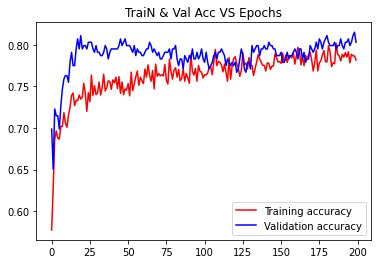

<Figure size 432x288 with 0 Axes>

In [41]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

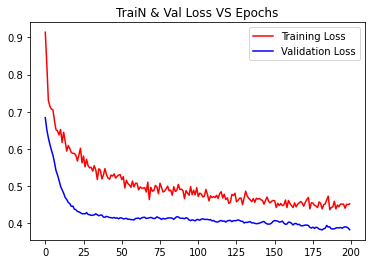

<Figure size 432x288 with 0 Axes>

In [42]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [43]:
model.load_weights("vgg16_model.h5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)
     

8/8 [==============================] - 4s 294ms/step - loss: 0.3866 - accuracy: 0.8153
Test Loss: 0.3865843117237091
Test accuracy: 81.52610659599304


8/8 [==============================] - 1s 82ms/step


Text(0.5, 1.0, 'Confusion Matrix')

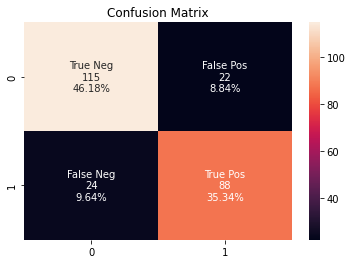

In [44]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")